## 1. 문제 정의
### Boston Housing

주택가격에 대한 데이터를 통해 주택의 가격에 영향을 미치는 요인을 분석하고자 한다. 그 후, 집값을 예측한다.

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib as mpl

import scipy as sp
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.font_manager as fm
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
mpl.rc('font',family= font_name)
import warnings
warnings.filterwarnings('ignore')

## 2. 데이터 수집

In [215]:
df_raw = pd.read_csv('/home/pirl/Downloads/data2_py/BOSTON_HOUSING.csv')
df_raw.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.000000,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,396.899994,4.98
1,21.600000,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,396.899994,9.14
2,34.700001,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,392.829987,4.03
3,33.400002,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,394.630005,2.94
4,36.200001,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,396.899994,5.33


## 3. 탐색적 자료 분석 및 데이터 정제
#### 데이터 설명
* _목표변수_  ] MEDV : 주택가격(중앙값)
* CRIM : 범죄율
* ZN : 주거지 비율
* INDUS : 비소매업 비율
* CHAS : 강 조망 여부 (1: 조망, 0: 비조망)
* NOX : 산화질소 농도
* RM : 주거당 평균 객실 수
* AGE : 노후 건물 비율
* DIS : 중심지(노동센터) 접근 거리
* RAD : 고속도로 접근 편이성 지수
* TAX : 재산세율
* PTRATIO : 학생당 교사 비율
* B : 흑인 인구 비율
* LSTAT : 저소득층 비율

In [4]:
df_raw.shape

(506, 14)

위의 데이터에는 506개의 행(주택가격에 대한 정보)이 있고, 14개의 열(특성 정보)이 있다.

In [41]:
df_raw.isnull().sum()

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

결측치는 없다.

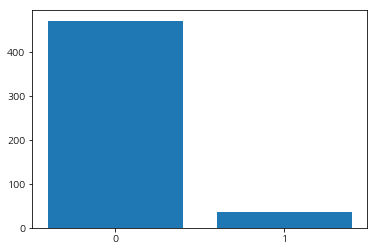

In [42]:
#이산형 데이터 (CHAS : 강 조망 여부)에 대한 막대차트를 그려보자.
chasvc = df_raw['CHAS'].value_counts()
plt.bar(['0','1'], [chasvc[0],chasvc[1]])
plt.show()

강의 경치가 보이지 않는 집이 훨씬 많음을 알 수 있다.
#### _이제, 목표변수에 대한 그래프 분석을 해보자!_

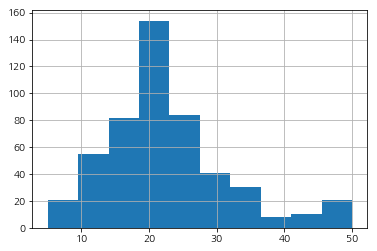

In [33]:
#주택가격(MEDV)에 대한 히스토그램 생성

df_raw['MEDV'].hist()

주택가격이 20을 근방으로 몰려있음을 확인할 수 있다.

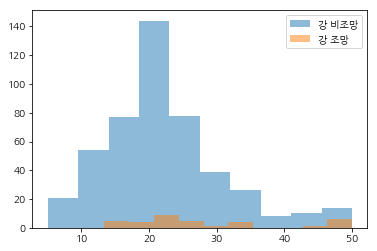

In [39]:
#강 조망 여부별 주택가격의 빈도를 중첩
plt.hist(df_raw[df_raw['CHAS'] == 0]['MEDV'],label='강 비조망',alpha=0.5)
plt.hist(df_raw[df_raw['CHAS'] == 1]['MEDV'],label='강 조망',alpha=0.5)
plt.legend()

값에 차이가 많기 때문에 비교하기 용이하지 않다. 따로 비교해볼 필요가 있어보인다.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f852b62e470>,
      dtype=object)

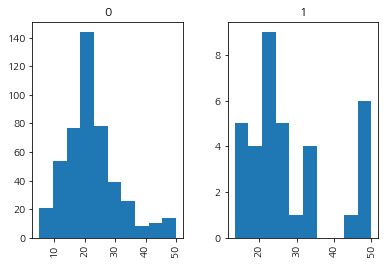

In [38]:
#강의 조망 여부(CHAS)별로 주택가격(MEDV)의 빈도의 분포 확인
df_raw.hist(column='MEDV', by='CHAS')

#### 강 조망 여부에서 중요한 정보를 얻을 수 있을까?

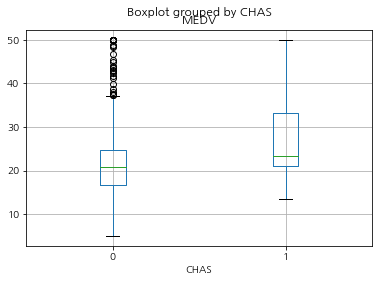

In [243]:
df_raw.boxplot(column='MEDV', by='CHAS')

상자그림에서도 알 수 있듯이 강의 경치가 보이는 경우(1)의 평균주택가격이 더 높음을 알 수 있다. 하지만, 그 차이가 매우 작기때문에 정확한 확인을 위한 검정절차를 실시한다.

_강의 경치가 보이는지에 따라 주택가격에 차이가 있는지 검정_
#### 2-sample t-test
* 귀무가설 : 강의 경치가 보이는지에 따라 주택가격에 차이가 없다.
* 대립가설 : 강의 경치가 보이는지에 따라 주택가격간에 차이가 있다.

In [50]:
#먼저, 두 표본집단에 대해 알아보자.
df_raw['CHAS'].value_counts()

0    471
1     35
Name: CHAS, dtype: int64

In [54]:
df_raw[df_raw['CHAS']==0]['MEDV'].describe()

count    471.000000
mean      22.093843
std        8.831362
min        5.000000
25%       16.600000
50%       20.900000
75%       24.799999
max       50.000000
Name: MEDV, dtype: float64

In [55]:
df_raw[df_raw['CHAS']==1]['MEDV'].describe()

count    35.000000
mean     28.440000
std      11.816643
min      13.400000
25%      21.100000
50%      23.299999
75%      33.150000
max      50.000000
Name: MEDV, dtype: float64

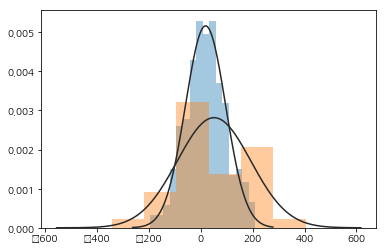

In [58]:
N_0 = 471
mu_0 = 22.09
sigma_0 = (8.83 ** 2)
N_1 = 35
mu_1 = 28.44
sigma_1 = (11.82 ** 2)
np.random.seed(0)
x0 = sp.stats.norm(mu_0, sigma_0).rvs(N_0)
x1 = sp.stats.norm(mu_1, sigma_1).rvs(N_1)
sns.distplot(x0, kde=False, fit=sp.stats.norm)
sns.distplot(x1, kde=False, fit=sp.stats.norm)
plt.show()

In [59]:
#각각의 표본 평균
np.mean(x0), np.mean(x1)

(19.07139599139687, 51.750723433026074)

In [60]:
#2-sample t-test
sp.stats.ttest_ind(x0, x1, equal_var=False)

Ttest_indResult(statistic=-1.330411000782238, pvalue=0.19187193297569566)

#### 위의 경우, p-value 가 19.19%로 귀무가설을 기각할 수 없다. 즉, 강의 경치가 보이는지에 따라 주택가격은 차이가 없다고 할 수 있다.
강의 경치가 보이는지 보이지 않는지에 따라 따로 그래프를 그려보았을 때는 강의 경치가 보이는 경우, 비교적 주택가격이 높은 것들이 많이 존재했다. 하지만 두 집단간의 표본 수의 차이가 크기 때문에 위와 같은 검정결과가 나온 것이라고 예측해볼 수 있다.

#### 잠재 인자 도출

In [ ]:
##1. 잠재인자 : 교통 (RAD - 고속도로 접근 편의성,DIS - 중심지 접근거리)

#RAD와 주택가격간의 관계를 Scatter Plot으로 생성
sns.scatterplot(x='RAD', y='MEDV', data=df_raw)

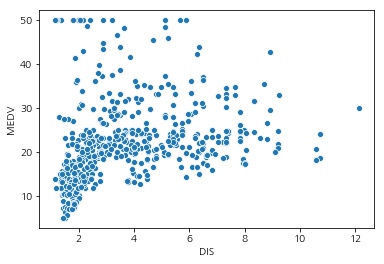

In [263]:
#DIS와 주택가격간의 관계를 Scatter Plot으로 생성
sns.scatterplot(x='DIS', y='MEDV', data=df_raw)

In [264]:
#연속형 데이터 (교통:RAD)의 범주화
for i in range(0, len(df_raw['RAD'])) :
    if (df_raw.iloc[i,9] < 12):
        df_raw.iloc[i,9] = 0
    elif (df_raw.iloc[i,9] >= 12):
        df_raw.iloc[i,9] = 1

#고속도로 접근 편의성(RAD)에 대해서는 12를 기준으로 12보다 작은 값은 0, 12와 같거나 큰 값은 1로 범주화 시킨다.

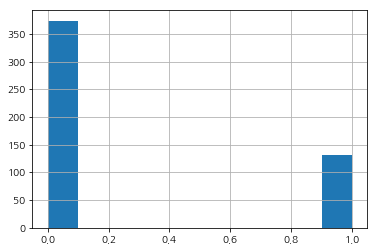

In [265]:
df_raw['RAD'].hist()

In [266]:
#연속형 데이터 (교통:DIS)의 범주화
for i in range(0, len(df_raw['DIS'])) :
    if (df_raw.iloc[i,8] <= 6):
        df_raw.iloc[i,8] = 0
    elif (df_raw.iloc[i,8] > 6):
        df_raw.iloc[i,8] = 1

#중심지 접근 거리(DIS)에 대해서는 6을 기준으로 6보다 같거나 작은 값은 0, 6보다 큰 값은 1로 범주화 시킨다.

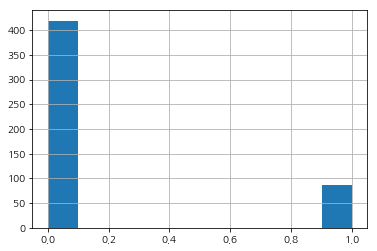

In [267]:
df_raw['DIS'].hist()

그럼 이제 범주화된 교통 자료와 주택가격간에 유의미한 관계가 있는지 알아보자.

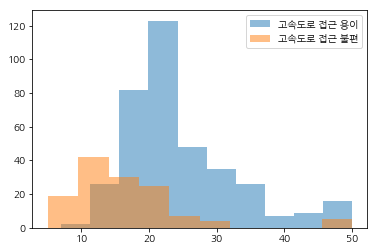

In [268]:
#교통의 편의성 여부별 주택가격의 빈도를 중첩
plt.hist(df_raw[df_raw['RAD'] == 0]['MEDV'],label='고속도로 접근 용이',alpha=0.5)
plt.hist(df_raw[df_raw['RAD'] == 1]['MEDV'],label='고속도로 접근 불편',alpha=0.5)
plt.legend()

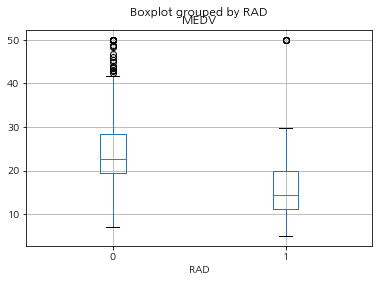

In [297]:
df_raw.boxplot(column='MEDV', by='RAD')

위의 상자그림을 보았을 때, 고속도로 접근의 편의성에 따라 유의미한 차이가 있을 것이라고 예측할 수 있다.

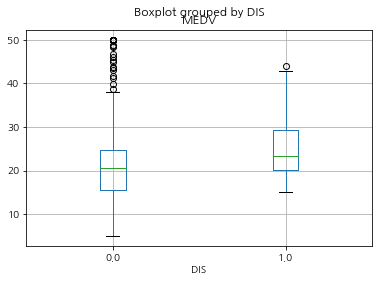

In [298]:
df_raw.boxplot(column='MEDV', by='DIS')

위의 상자그림을 보았을 때, 중심지 접근 거리에 따른 평균값의 차이는 거의 없기 때문에 유의미한 차이를 찾기 어려울 것이라고 예측할 수 있다.

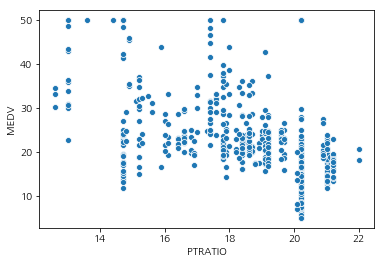

In [299]:
##2. 잠재인자 : 교육 (PTRATIO - 학생당 교사 비율)

#PTRATIO와 주택가격간의 관계를 Scatter Plot으로 생성
sns.scatterplot(x='PTRATIO', y='MEDV', data=df_raw)

In [300]:
#학생당 교사 비율과 주택가격간의 상관계수
df_raw['MEDV'].corr(df_raw['PTRATIO'])

-0.5077867038116084

음의 상관관계를 갖고 있음을 확인할 수 있다. 그렇다면 학생당 교사의 비율이 증가할수록 주택가격이 감소하는 경향을 예측할 수 있다.

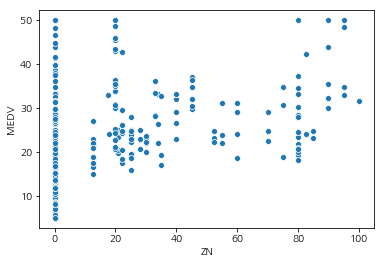

In [301]:
##3. 잠재인자 : 상권 (ZN - 주거지 비율, INDUS - 비소매업 비율)

#ZN과 주택가격간의 관계를 Scatter Plot으로 생성
sns.scatterplot(x='ZN', y='MEDV', data=df_raw)

상관관계를 찾기 어렵다.

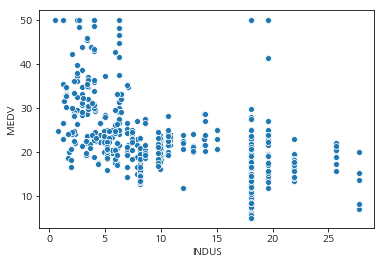

In [302]:
#INDUS와 주택가격간의 관계를 Scatter Plot으로 생성
sns.scatterplot(x='INDUS', y='MEDV', data=df_raw)

비소매업 비율과 주택가격간에 상관관계가 있어 보인다.

In [305]:
#비소매업 비율과 주택가격간의 상관계수
df_raw['MEDV'].corr(df_raw['INDUS'])

-0.4837251712814337

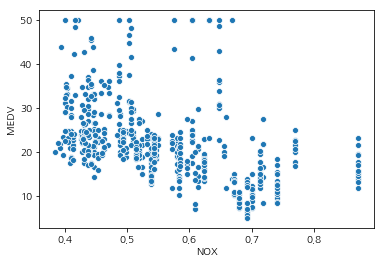

In [306]:
##4. 잠재인자 : 환경 (NOX - 산화질소 농도, CRIM - 범죄율)

#NOX와 주택가격간의 관계를 Scatter Plot으로 생성
sns.scatterplot(x='NOX', y='MEDV', data=df_raw)

약한 음의 상관관계가 있어보인다.

In [307]:
#산화질소 농도와 주택가격간의 상관계수
df_raw['MEDV'].corr(df_raw['NOX'])

-0.4273207763683763

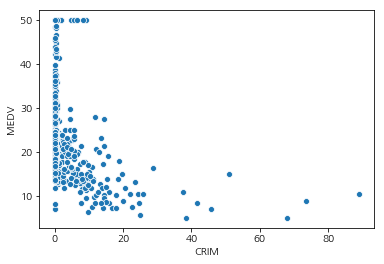

In [308]:
#CRIM와 주택가격간의 관계를 Scatter Plot으로 생성
sns.scatterplot(x='CRIM', y='MEDV', data=df_raw)

약한 음의 상관관계가 있어보인다.

In [309]:
#범죄율과 주택가격간의 상관계수
df_raw['MEDV'].corr(df_raw['CRIM'])

-0.3883046116575093

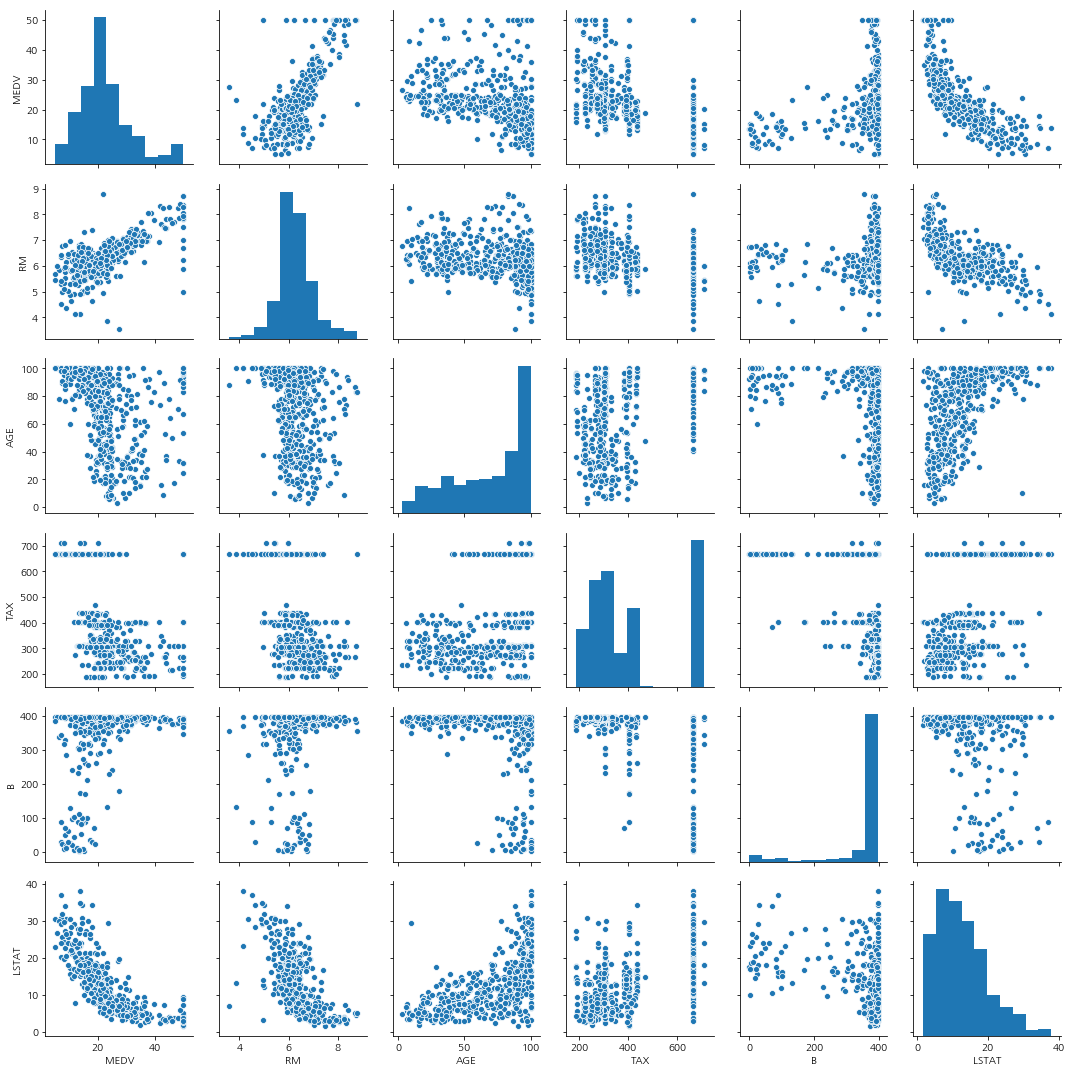

In [318]:
#강조망여부와 도출된 잠재인자를 제외한 나머지 설명변수와 주택가격간의 산점도 행렬을 그려본다.
df_raw_md = df_raw.drop(['CRIM','ZN','INDUS','CHAS','NOX','DIS','RAD','PTRATIO'],axis=1)
sns.pairplot(df_raw_md)

In [319]:
df_raw_md.corr()

,MEDV,RM,AGE,TAX,B,LSTAT
MEDV,1.000000,0.695360,-0.376955,-0.468536,0.333461,-0.737663
RM,0.695360,1.000000,-0.240265,-0.292048,0.128069,-0.613808
AGE,-0.376955,-0.240265,1.000000,0.506456,-0.273534,0.602339
TAX,-0.468536,-0.292048,0.506456,1.000000,-0.441808,0.543993
B,0.333461,0.128069,-0.273534,-0.441808,1.000000,-0.366087
LSTAT,-0.737663,-0.613808,0.602339,0.543993,-0.366087,1.000000


위의 산점도 행렬과 상관계수 값을 참고하여 주택가격에 유의미한 영향을 주는 변수들로만 데이터를 재생성해보자.

In [320]:
df = df_raw.drop(['ZN','CHAS','AGE','DIS','B'], axis=1)

## 4. 모델 생성
### (1) 다중 회귀